In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32,copy=False)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32,copy=False)
print("Done.")

Loading dataset....
Done.


In [3]:
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).astype(np.float32,copy=False)

In [4]:
import cupy as cp

In [5]:
X_train=cp.asarray(X_train)

In [6]:
import sys
sys.path.append("../dnn_from_scratch")

In [7]:
from nnet_gpu.network import Sequential,layers
from nnet_gpu.layers import dense
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np

Seed: 863


In [8]:
def generator():
    model=Sequential()
    model.add(dense(128,input_shape=(100),activation=functions.leakyRelu))
#     model.add(dropout(0.3))
    model.add(dense(256,activation=functions.leakyRelu))
#     model.add(dropout(0.3))
    model.add(dense(784,activation=functions.tanh))
    return model
g=generator()

In [9]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
0 dense(dense)            (None, 128)                leakyRelu        12928
__________________________________________________________________________________________
1 dense(dense)            (None, 256)                leakyRelu        33024
__________________________________________________________________________________________
2 dense(dense)            (None, 784)                tanh             201488
Total Params: 247,440
Trainable Params: 247,440
Non-trainable Params: 0


In [10]:
def discriminator():
    model=Sequential()
    model.add(dense(256,input_shape=(784),activation=functions.leakyRelu))
#     model.add(dropout(0.3))
    model.add(dense(128,activation=functions.leakyRelu))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()

In [11]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 784)                echo             0
__________________________________________________________________________________________
0 dense(dense)            (None, 256)                leakyRelu        200960
__________________________________________________________________________________________
1 dense(dense)            (None, 128)                leakyRelu        32896
__________________________________________________________________________________________
2 dense(dense)            (None, 1)                  sigmoid          129
Total Params: 233,985
Trainable Params: 233,985
Non-trainable Params: 0


In [12]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [13]:
def run(batch_size=64):
    dsz=X_train.shape[0]
    y_fake=cp.zeros((batch_size,1),dtype=cp.float32)
    y_real=cp.ones((batch_size,1),dtype=cp.float32)
    y_gen=cp.ones((batch_size,1),dtype=cp.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=cp.random.randn(batch_size,100).astype(cp.float32,copy=False)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = cp.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=cp.random.uniform(0.9,1,(batch_size,1)).astype(cp.float32,copy=False)
        y_fake=cp.random.uniform(0,0.1,(batch_size,1)).astype(cp.float32,copy=False)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum().get()
        # Treat noised icput of generator as real data
        noise=cp.random.randn(batch_size,100).astype(cp.float32,copy=False)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 10
Progress: 99.84 %     Dloss: 26.20672607421875    err: 0.012641272     Sample time: 0.007s    _ _
Epoch time: 0:8s


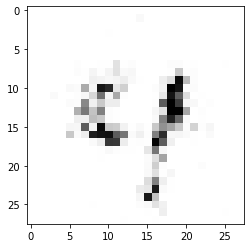

[0.37752196]
EPOCH: 2 / 10
Progress: 99.84 %     Dloss: 27.798625946044922    err: 0.012083716     Sample time: 0.008s    __
Epoch time: 0:8s


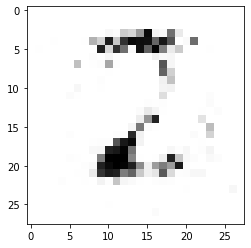

[0.07926747]
EPOCH: 3 / 10
Progress: 99.84 %     Dloss: 28.47381591796875    err: 0.011649045     Sample time: 0.007s    ___
Epoch time: 0:8s


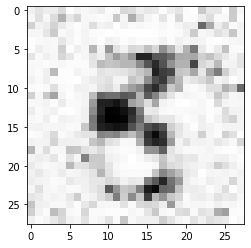

[0.08376624]
EPOCH: 4 / 10
Progress: 99.84 %     Dloss: 40.25379180908203    err: 0.008418246     Sample time: 0.009s    ___
Epoch time: 0:9s


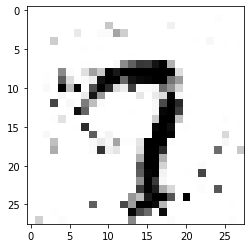

[0.3705609]
EPOCH: 5 / 10
Progress: 99.84 %     Dloss: 28.212158203125    err: 0.008603047     Sample time: 0.006s    _____
Epoch time: 0:8s


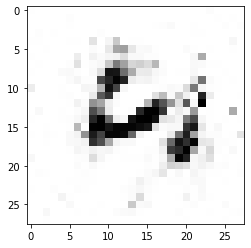

[0.45709234]
EPOCH: 6 / 10
Progress: 99.84 %     Dloss: 32.852500915527344    err: 0.009247952     Sample time: 0.007s    __
Epoch time: 0:8s


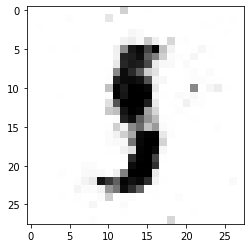

[0.606207]
EPOCH: 7 / 10
Progress: 99.84 %     Dloss: 26.890735626220703    err: 0.010125387     Sample time: 0.007s    __
Epoch time: 0:8s


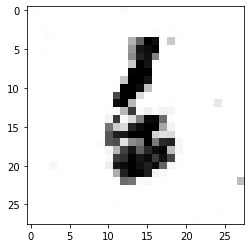

[0.03814194]
EPOCH: 8 / 10
Progress: 99.84 %     Dloss: 37.61017990112305    err: 0.008309599     Sample time: 0.007s    ___
Epoch time: 0:8s


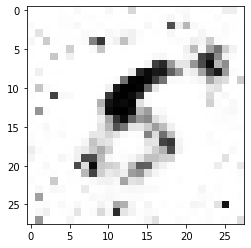

[0.1241584]
EPOCH: 9 / 10
Progress: 99.84 %     Dloss: 24.103126525878906    err: 0.008690628     Sample time: 0.008s    __
Epoch time: 0:8s


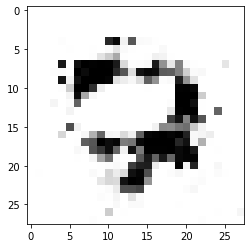

[0.3774816]
EPOCH: 10 / 10
Progress: 99.84 %     Dloss: 26.07002830505371    err: 0.0079762135     Sample time: 0.006s    __
Epoch time: 0:8s


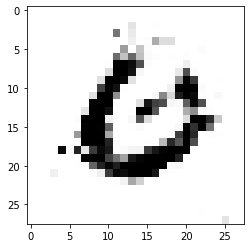

[0.4870042]


In [17]:
epochs=10
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(64)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=cp.random.randn(1,100).astype(cp.float32,copy=False)
    gen=g.predict(noise).get()
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

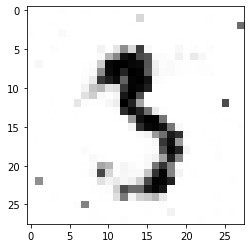

[[0.3482915]]


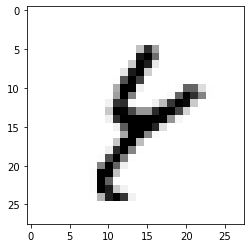

[[0.2731128]]


In [18]:
noise=cp.random.randn(1,100).astype(cp.float32,copy=False)
gen=g.predict(noise).get()
plt.imshow(gen.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(gen))
img=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=1)].get()
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))

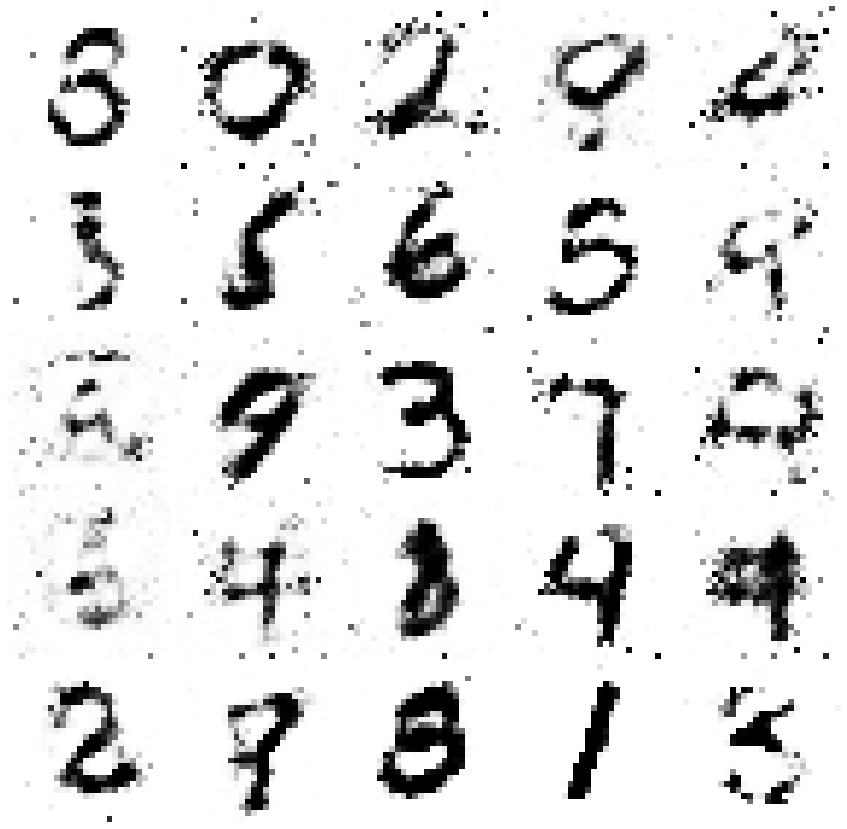

In [19]:
# After 10 epochs
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[15,15],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
noise=cp.random.randn(25,100).astype(cp.float32,copy=False)
gen=g.predict(noise).get()
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow(gen[i].reshape(28,28), cmap='Greys')